In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing,
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob

In [3]:
import cv2 as cv

def read_image(file):
    img = cv.imread(file)
    img = cv.resize(img, (64, 64))
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    img = img.astype("float32")/255
    return img

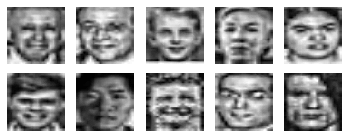

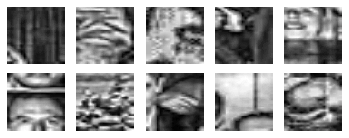

In [6]:
# Pre processing the dataset
face_list = []
for filename in glob.glob("face_detection_data/face/*.png"):
    img = read_image(filename)
    face_list.append(img)

non_face_list = []   
for filename in glob.glob("face_detection_data/non-face/*.png"):
    img = read_image(filename)
    non_face_list.append(img)

rows = 2
columns = 5
fig, axs = plt.subplots(rows, columns, gridspec_kw = {'wspace': 0.2, 'hspace': -0.56})

for i in range(rows):
    for j in range(columns):
        axs[i][j].imshow(face_list[i*columns+j], cmap="gray")
        axs[i][j].axis('off')
        axs[i][j].set_aspect('equal')
plt.show()

fig, axs = plt.subplots(rows, columns, gridspec_kw = {'wspace': 0.2, 'hspace': -0.56})

for i in range(rows):
    for j in range(columns):
        axs[i][j].imshow(non_face_list[i*columns+j], cmap="gray")
        axs[i][j].axis('off')
        axs[i][j].set_aspect('equal')
plt.show()

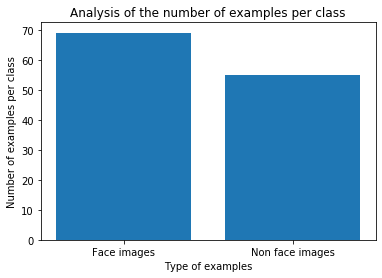

In [7]:
plt.bar(["Face images","Non face images"], [len(face_list), len(non_face_list)])
plt.ylabel("Number of examples per class")
plt.xlabel("Type of examples")
plt.title("Analysis of the number of examples per class")
plt.show()

# Data Augmentation

In [8]:
from skimage.util import random_noise

# example of horizontal flip image augmentation
augmented_face_images = []
for face_img in face_list:
    flipped_face_img = cv.flip(face_img, flipCode=1)
    augmented_face_images.append(flipped_face_img)
    augmented_face_images.append(np.flipud(face_img))
    augmented_face_images.append(np.fliplr(face_img))


augmented_non_face_images = []
for non_face_img in non_face_list:
    flipped_non_face_img = cv.flip(non_face_img, flipCode=1)
    augmented_non_face_images.append(flipped_non_face_img)
    augmented_non_face_images.append(np.flipud(non_face_img))
    augmented_non_face_images.append(np.fliplr(non_face_img))
    augmented_non_face_images.append(random_noise(non_face_img))

face_list.extend(augmented_face_images)
non_face_list.extend(augmented_non_face_images)

y_face_list = np.ones(len(face_list))
print(len(face_list))
y_non_face_list = np.zeros(len(non_face_list))

276


In [9]:
full_dataset = []
full_dataset.extend(face_list)
full_dataset.extend(non_face_list)
print(len(full_dataset))

551


# HOG Feature Extraction

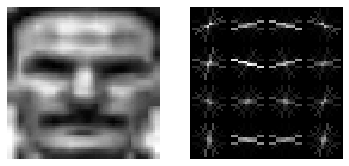

In [10]:
from skimage.feature import hog
import random
from sklearn.utils import shuffle

full_dataset_y = np.append(y_face_list, y_non_face_list, 0)

ppc = 16
hog_images = []
hog_features = []

for image in full_dataset:
    fd, hog_image = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
    hog_images.append(hog_image)
    hog_features.append(fd)

plt.subplot(1, 2, 1)
plt.imshow(full_dataset[50], cmap="gray")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(hog_images[50], cmap="gray")
plt.axis("off")
plt.show()

# SVM With K-Fold CV

In [11]:
def dataset3Params(X, y, splits,vals):
    """
    dataset3Params returns the optimal C and gamma(1/sigma) based on a cross-validation set.
    """
    acc = 0
    best_C=0
    best_gamma=0
    score_history=[]
    score_history_train=[]
    
    parameeter_history=[]
    for i in vals:
        C= i
        for j in vals:
            gamma = 1/j
            classifier = svm.SVC(C=C, gamma=gamma, kernel="rbf")
            kfold = KFold(n_splits=5, shuffle=True)
            scores = cross_validate(classifier, X, y, cv=kfold, return_train_score=True)
            #print(scores.keys())
            score_test = scores["test_score"].mean()
            score_train = scores["train_score"].mean()

            score_history.append(score_test)
            score_history_train.append(score_train)

            parameeter_history.append(str((C, gamma)))
            
            if score_test > acc:
                acc =score_test
                best_C =C
                best_gamma=gamma
                
    
    '''plt.figure(num=1,figsize=(15,8),dpi=1200)
    plt.rcParams.update({"font.size":12})
    plt.plot(parameeter_history,score_history,label="cross validation accuracy")
    plt.plot(parameeter_history,score_history_train,label="train accuracy")

    plt.xlabel("Training examples (C,Gamma) ")
    plt.xticks(rotation=90)
    plt.ylabel("Accuracy")
    plt.ylim([0, 1.05])
    plt.legend(loc='lower right')
    plt.title(f"K-Fold with {splits} splits")
    plt.show()'''
    

    return best_C, best_gamma

In [12]:
from sklearn import svm
from sklearn.model_selection import train_test_split,cross_validate, KFold
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

labels =  full_dataset_y.reshape(len(full_dataset_y), 1)

vals = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

accuracy_scores_train = []
precision_scores_train = []
recall_scores_train = []
f1_scores_train = []

final_classifier = None
best_f1_score = 0
best_accuracy_score = 0

for i in range(50):
    hog_features = np.array(hog_features)

    x_train, x_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.20)
    best_C, best_gamma = dataset3Params(x_train, y_train.ravel(), 5, vals)
    print(f"Best C: {best_C}")
    print(f"Best gamma: {best_gamma}\n")

    classifier = svm.SVC(gamma=best_gamma, C=best_C, kernel="rbf")
    classifier.fit(x_train, y_train.ravel())
    if i == 0:
    final_classifier = classifier

    y_pred = classifier.predict(x_test)
    y_train_pred = classifier.predict(x_train)

    if f1_score(y_test, y_pred, average="macro") > best_f1_score and accuracy_score(y_test, y_pred) > best_accuracy_score:
    best_f1_score = f1_score(y_test, y_pred, average="macro")
    best_accuracy_score = accuracy_score(y_test, y_pred)
    final_classifier = classifier

    f1_scores.append(f1_score(y_test, y_pred, average="macro"))
    precision_scores.append(precision_score(y_test, y_pred, average="macro"))
    recall_scores.append(recall_score(y_test, y_pred, average="macro"))
    accuracy_scores.append(accuracy_score(y_test, y_pred))

    f1_scores_train.append(f1_score(y_train, y_train_pred, average="macro"))
    precision_scores_train.append(precision_score(y_train, y_train_pred, average="macro"))
    recall_scores_train.append(recall_score(y_train, y_train_pred, average="macro"))
    accuracy_scores_train.append(accuracy_score(y_train, y_train_pred))

print(f"F1 score: {sum(f1_scores)/len(f1_scores)}\n")
print(f"Precision score: {sum(precision_scores)/len(precision_scores)}\n")
print(f"Recall score: {sum(recall_scores)/len(recall_scores)}\n")
print(f"Accuracy score: {sum(accuracy_scores)/len(accuracy_scores)}\n")

print(f"F1 train score: {sum(f1_scores_train)/len(f1_scores_train)}\n")
print(f"Precision train score: {sum(precision_scores_train)/len(precision_scores_train)}\n")
print(f"Recall train score: {sum(recall_scores_train)/len(recall_scores_train)}\n")
print(f"Accuracy train score: {sum(accuracy_scores_train)/len(accuracy_scores_train)}\n")

Best C: 30
Best gamma: 1.0

F1 score: 0.981438127090301

Precision score: 0.9787234042553192

Recall score: 0.9848484848484849

Accuracy score: 0.9819819819819819

F1 train score: 1.0

Precision train score: 1.0

Recall train score: 1.0

Accuracy train score: 1.0



In [13]:
y_pred = final_classifier.predict(x_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.9819819819819819

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98        66
         1.0       0.96      1.00      0.98        45

    accuracy                           0.98       111
   macro avg       0.98      0.98      0.98       111
weighted avg       0.98      0.98      0.98       111



In [18]:
def plot_confusion_matrix(cls_pred,Y_test_cls,num_classes):

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = Y_test_cls
    
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()

[[64  2]
 [ 0 45]]


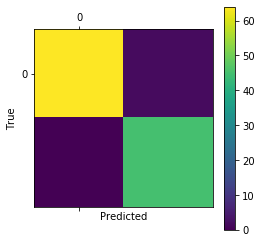

In [19]:
y_pred=classifier.predict(x_test)

plot_confusion_matrix(cls_pred=y_pred,Y_test_cls=y_test,num_classes=y_test.shape[1])

# SVM with external image

# External examples : face or non face ?

## Astronaut

In [ ]:
import skimage.transform

test_image = skimage.data.astronaut()
test_image = cv.cvtColor(test_image, cv.COLOR_BGR2GRAY)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[10:90, 80:150]
test_image = cv.resize(test_image, (64, 64))
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
test_image = test_image.astype("float32")/255

plt.imshow(test_image, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
hog_features_astronaut = hog(test_image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1))

y_pred = final_classifier.predict(hog_features_astronaut.reshape(1,-1))
print(f"External image, face(1) or non-face(0): {int(y_pred[0])}")

## Child

In [ ]:
import skimage.transform

test_image = read_image("/kaggle/input/real-and-fake-face-detection/real_and_fake_face_detection/real_and_fake_face/training_real/real_00228.jpg")

plt.imshow(test_image, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
hog_features_kid = hog(test_image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1))

y_pred = final_classifier.predict(hog_features_kid.reshape(1,-1))
print(f"External image, face(1) or non-face(0): {int(y_pred[0])}")

## Multiple people

In [ ]:
import skimage.transform

img = cv.imread("/kaggle/input/externalimagefamily/im4.jpeg")
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img = clahe.apply(img)
test_image = img.astype("float32")/255


plt.imshow(test_image, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
from skimage.feature import hog

def sliding_window(img, patch_size=(64,64), istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([hog(patch, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1)) for patch in patches])
patches_hog.shape

labels = final_classifier.predict(patches_hog)
labels.sum()

In [24]:
def doOverlap(l1, r1, l2, r2): 
      
    # If one rectangle is on left side of other 
    if(l1[0] > r2[0] or l2[0] > r1[0]): 
        return False
  
    # If one rectangle is above other 
    if(l1[1] < r2[1] or l2[1] < r1[1]): 
        return False
  
    return True

In [25]:
def checkOverlap(l1, r1, rectangles): 
    overlap=False
    
    for rec in rectangles:
        l2=rec[0]
        r2=rec[1]
      
        overlap=doOverlap(l1,r1,l2,r2)
        if overlap:
            return True

In [ ]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = (64,64)
indices = np.array(indices)
l1=[0,0]
r1=[0,0]
l2=[0,0]
r2=[0,0]
rectangles=[]

for i, j in indices[labels == 1]:
    l1[0]=j
    l1[1]=i+64
    r1[0]=j+64
    r1[1]=i
    
    if(not checkOverlap(l1, r1, rectangles)):
        rectangles.append([l1, r1])
        ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red', alpha=0.8, lw=2, facecolor='none'))
    l1=[0,0]
    r1=[0,0]

plt.show()

# Neural Network

In [20]:
from sklearn import svm
from sklearn.model_selection import train_test_split,cross_validate, KFold
from sklearn.metrics import classification_report,accuracy_score
from sklearn.neural_network import MLPClassifier

labels =  full_dataset_y.reshape(len(full_dataset_y), 1)

In [21]:
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

@ignore_warnings(category=ConvergenceWarning)
def nn_cv(X, y, splits, combinations):
    """
    dataset3Params returns the optimal C and gamma(1/sigma) based on a cross-validation set.
    """
    acc = 0
    best_alpha=0
    best_hidden_layer_size=0
    best_num_iterations=0

    score_history=[]
    score_history_train=[]
    
    parameeter_history=[]
    for alpha, hidden_layer_size, iterations in combinations:
        
        classifier = MLPClassifier(alpha=alpha, hidden_layer_sizes=(hidden_layer_size,), solver="lbfgs", max_iter=iterations)
        kfold = KFold(n_splits=5,shuffle=True)
        scores = cross_validate(classifier, X, y, cv=kfold, return_train_score=True)
        
        score_test = scores["test_score"].mean()
        score_train = scores["train_score"].mean()

        score_history.append(score_test)
        score_history_train.append(score_train)
        parameeter_history.append(str((alpha,hidden_layer_size,iterations)))
        if score_test > acc:
            acc =score_test
            best_alpha = alpha
            best_hidden_layer_size=hidden_layer_size
            best_num_iterations=iterations

    '''plt.figure(num=1,figsize=(35,8),dpi=1200)
    plt.rcParams.update({"font.size":12})
    plt.plot(parameeter_history,score_history,label="cross validation accuracy")
    plt.plot(parameeter_history,score_history_train,label="train accuracy")
    plt.xlabel("Training examples (alpha,hidden layer size,num iterations) ")
    plt.xticks(parameeter_history[::5],rotation=90)
    plt.ylabel("Accuracy")
    plt.ylim([0, 1.05])
    plt.legend(loc='lower right')
    plt.title(f"K-Fold with {splits} splits")
    plt.show()'''

    return best_alpha, best_hidden_layer_size, best_num_iterations

In [24]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

alpha = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 10]
min_hidden_size = 10
max_hidden_size = 70
step_hidden_size = 10
min_num_iterations = 100
step_num_iterations = 100
max_num_iterations = 1000
hidden_layer_size = []
num_iterations = []

for i in range(min_hidden_size, max_hidden_size+1, step_hidden_size):
    hidden_layer_size.append(i)

for i in range(min_num_iterations, max_num_iterations+1, step_num_iterations):
    num_iterations.append(i)

combinations=[(a,h,n) for a in alpha for h in hidden_layer_size for n in num_iterations]

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

accuracy_scores_train = []
precision_scores_train = []
recall_scores_train = []
f1_scores_train = []

#for i in range(10):

hog_features = np.array(hog_features)
x_train, x_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.20)
best_alpha, best_hidden_layer_size, best_num_iterations = nn_cv(x_train, y_train.ravel(), 5,combinations)

print(f"Best alpha: {best_alpha}")
print(f"Best hidden layer size: {best_hidden_layer_size}")
print(f"Best num iterations: {best_num_iterations}")

classifier = MLPClassifier(alpha=best_alpha, hidden_layer_sizes=(best_hidden_layer_size,), solver="lbfgs", max_iter=best_num_iterations)
classifier.fit(x_train,y_train.ravel())

y_pred = classifier.predict(x_test)
y_train_pred = classifier.predict(x_train)

f1_scores.append(f1_score(y_test, y_pred, average="macro"))
precision_scores.append(precision_score(y_test, y_pred, average="macro"))
recall_scores.append(recall_score(y_test, y_pred, average="macro"))
accuracy_scores.append(accuracy_score(y_test, y_pred))

f1_scores_train.append(f1_score(y_train, y_train_pred, average="macro"))
precision_scores_train.append(precision_score(y_train, y_train_pred, average="macro"))
recall_scores_train.append(recall_score(y_train, y_train_pred, average="macro"))
accuracy_scores_train.append(accuracy_score(y_train, y_train_pred))

print(f"F1 score: {sum(f1_scores)/len(f1_scores)}\n")
print(f"Precision score: {sum(precision_scores)/len(precision_scores)}\n")
print(f"Recall score: {sum(recall_scores)/len(recall_scores)}\n")
print(f"Accuracy score: {sum(accuracy_scores)/len(accuracy_scores)}\n")

print(f"F1 train score: {sum(f1_scores_train)/len(f1_scores_train)}\n")
print(f"Precision train score: {sum(precision_scores_train)/len(precision_scores_train)}\n")
print(f"Recall train score: {sum(recall_scores_train)/len(recall_scores_train)}\n")
print(f"Accuracy train score: {sum(accuracy_scores_train)/len(accuracy_scores_train)}\n")

Best alpha: 0.01
Best hidden layer size: 50
Best num iterations: 300
F1 score: 0.9272131147540984

Precision score: 0.9259803921568628

Recall score: 0.9290651744568795

Accuracy score: 0.9279279279279279

F1 train score: 1.0

Precision train score: 1.0

Recall train score: 1.0

Accuracy train score: 1.0



In [25]:
y_pred = classifier.predict(x_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.9279279279279279

              precision    recall  f1-score   support

         0.0       0.95      0.92      0.93        62
         1.0       0.90      0.94      0.92        49

    accuracy                           0.93       111
   macro avg       0.93      0.93      0.93       111
weighted avg       0.93      0.93      0.93       111



[[57  5]
 [ 3 46]]


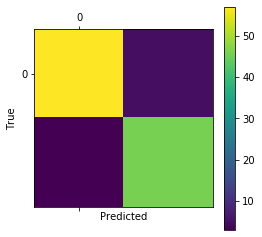

In [26]:
y_pred=classifier.predict(x_test)

plot_confusion_matrix(cls_pred=y_pred,Y_test_cls=y_test,num_classes=y_test.shape[1])

# External examples : face or non face ?

## Astronaut


In [ ]:
import skimage.transform

test_image = skimage.data.astronaut()
test_image = cv.cvtColor(test_image, cv.COLOR_BGR2GRAY)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[10:90, 80:150]
test_image = cv.resize(test_image, (64, 64))
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
test_image = test_image.astype("float32")/255

plt.imshow(test_image, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
hog_features_astronaut = hog(test_image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1))

y_pred = classifier.predict(hog_features_astronaut.reshape(1,-1))
print(f"External image, face(1) or non-face(0) : {int(y_pred[0])}")

## Child

In [ ]:
import skimage.transform

test_image = read_image("/kaggle/input/real-and-fake-face-detection/real_and_fake_face_detection/real_and_fake_face/training_real/real_00228.jpg")

plt.imshow(test_image, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
hog_features = hog(test_image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1))

y_pred = classifier.predict(hog_features.reshape(1,-1))
print(f"External image, face(1) or non-face(0) : {int(y_pred[0])}")

## Multiple people

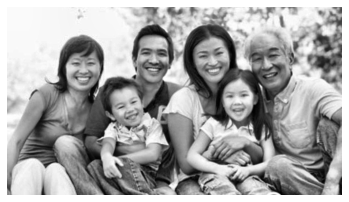

In [23]:
import skimage.transform

img = cv.imread("/kaggle/input/externalimagefamily/im4.jpeg")
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img = clahe.apply(img)
test_image = img.astype("float32")/255


plt.imshow(test_image, cmap='gray')
plt.axis('off')
plt.show()

In [26]:
from skimage.feature import hog

def sliding_window(img, patch_size=(64,64),
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([hog(patch, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1)) for patch in patches])
patches_hog.shape

labels = classifier.predict(patches_hog)
labels.sum()

1637.0

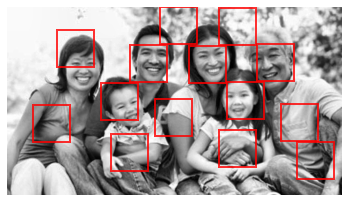

In [27]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = (64,64)
indices = np.array(indices)
l1=[0,0]
r1=[0,0]
l2=[0,0]
r2=[0,0]
rectangles=[]

for i, j in indices[labels == 1]:
    l1[0]=j
    l1[1]=i+64
    r1[0]=j+64
    r1[1]=i
    
    if(not checkOverlap(l1,r1,rectangles)):
        rectangles.append([l1,r1])
        ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',alpha=0.8, lw=2, facecolor='none'))
    l1=[0,0]
    r1=[0,0]
    
plt.show()